In [1]:
%matplotlib inline

import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns
from sklearn.model_selection import train_test_split


sns.set_style('white')

# Prediction

For investors it's interesting to know which characteristics of a loan are predictive of a loan ending in charged off. Lending club has its own algorithms beforehand that they use to predict which loans are riskier and give these a grade (A-F). This correlates well with the probability of charged off as we saw in the exploration of the dataset. The interest rates should reflect the risk (higher interest with more risk) to make the riskier loans still attractive to invest in. Although grade and interest correlates well, it's not a perfect correlation. 

We will here use the loans that went to full term to build classifiers that can classify loans into charged off and fully paid. The accuracy measure used is 'f1_weighted' of sklearn. This score can be interpreted as a weighted average of the precision and recall. Also confusion matrices and ROC curves will be used for analysis. Grade is used as baseline prediction for charged off/fully paid. We will look for features that add extra predictive value on top of the grade feature and see if this gives us any insight.

### Select loans and features
We selected the loans here that went to full term and add the characteristic whether they were charged off or not. We excluded the one loan that was a joint application. The number of loans left are 255,719. And the percentage of charged_off loans is 18%.

In [2]:
loans = pd.read_csv('../data/loan.csv')
closed_status = ['Fully Paid', 'Charged Off',
              'Does not meet the credit policy. Status:Fully Paid',
              'Does not meet the credit policy. Status:Charged Off']
closed_loans = loans[loans['loan_status'].isin(closed_status)]
paid_status = ['Fully Paid', 'Does not meet the credit policy. Status:Fully Paid']
closed_loans['charged_off'] = [False if loan in paid_status else True for loan in closed_loans['loan_status']]

# exclude the one joint application
closed_loans = closed_loans[closed_loans['application_type'] == 'INDIVIDUAL']
closed_loans['grade'] = closed_loans['grade'].astype('category', ordered=True)
print(closed_loans.shape)
round(sum(closed_loans['charged_off'])/len(closed_loans['charged_off'])*100)

/Users/ro.d.bruijn/anaconda/lib/python3.5/site-packages/IPython/core/interactiveshell.py:2902: DtypeWarning: Columns (19,55) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)
/Users/ro.d.bruijn/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


(255719, 75)


18.0

### Select features
We selected features that can be included for the prediction. For this we left out features that are not known at the beginning, like 'total payment'. Because these are not useful features to help new investors. Also non-predictive features like 'id' or features that have all the same values are also excluded. All features to do with 'joint' loans are also excluded, since we do not have joint loans. We did add loan_status and charged_off for the prediction. Furthermore, features that were missing in more than 5% of the loans were excluded leaving 24 features (excluding the targets loan_status and charged_off). 

In [3]:
include = ['funded_amnt_inv', 'term', 'int_rate', 'installment', 'grade', 'sub_grade', 'emp_length', 'home_ownership', 
          'annual_inc', 'purpose', 'zip_code', 'addr_state', 'delinq_2yrs', 'earliest_cr_line', 'inq_last_6mths', 
          'mths_since_last_delinq', 'mths_since_last_record', 'open_acc', 'pub_rec', 'revol_bal', 'revol_util', 'total_acc', 
          'mths_since_last_major_derog', 'acc_now_delinq', 'loan_amnt', 'funded_amnt', 'open_il_6m', 'open_il_12m', 
          'open_il_24m', 'mths_since_rcnt_il', 'total_bal_il', 'dti', 'open_acc_6m', 'tot_cur_bal',
          'il_util', 'open_rv_12m', 'open_rv_24m', 'max_bal_bc', 'all_util', 'total_rev_hi_lim', 'inq_fi', 'total_cu_tl',
          'inq_last_12m', 'charged_off', 'loan_status']

exclude = ['verfication_status', 'total_pymnt_inv', 'total_rec_prncp', 'total_rec_int', 'total_rec_late_fee',
           'recoveries', 'collection_recovery_fee', 'last_pymnt_d', 'last_credit_pull_d', 'collections_12_mths_ex_med', 
           'initial_list_status', 'id', 'member_id', 'emp_title', 'pymnt_plan', 'url', 'desc', 'title', 
           'out_prncp', 'out_prncp_inv', 'total_pymnt', 'last_pymnt_amnt', 'issue_d', 'next_pymnt_d', 'policy_code', 
           'application_type', 'annual_inc_joint', 'dti_joint', 'verification_status_joint', 'tot_coll_amt',
           ]

# include only the features above
closed_loans = closed_loans[include]

# exclude features with more than 5% missing values
columns_not_missing = (closed_loans.isnull().apply(sum, 0) / len(closed_loans)) < 0.05
closed_loans = closed_loans.loc[:,columns_not_missing[columns_not_missing].index]

closed_loans.shape

(255719, 26)

In [4]:
closed_loans.head()

,funded_amnt_inv,term,int_rate,installment,grade,sub_grade,emp_length,home_ownership,annual_inc,purpose,...,pub_rec,revol_bal,revol_util,total_acc,acc_now_delinq,loan_amnt,funded_amnt,dti,charged_off,loan_status
0,4975.0,36 months,10.65,162.87,B,B2,10+ years,RENT,24000.0,credit_card,...,0.0,13648.0,83.7,9.0,0.0,5000.0,5000.0,27.65,False,Fully Paid
1,2500.0,60 months,15.27,59.83,C,C4,< 1 year,RENT,30000.0,car,...,0.0,1687.0,9.4,4.0,0.0,2500.0,2500.0,1.00,True,Charged Off
2,2400.0,36 months,15.96,84.33,C,C5,10+ years,RENT,12252.0,small_business,...,0.0,2956.0,98.5,10.0,0.0,2400.0,2400.0,8.72,False,Fully Paid
3,10000.0,36 months,13.49,339.31,C,C1,10+ years,RENT,49200.0,other,...,0.0,5598.0,21.0,37.0,0.0,10000.0,10000.0,20.00,False,Fully Paid
5,5000.0,36 months,7.90,156.46,A,A4,3 years,RENT,36000.0,wedding,...,0.0,7963.0,28.3,12.0,0.0,5000.0,5000.0,11.20,False,Fully Paid


### Split data
We keep 30% of the data separate for now so we can later use this to reliable test the performance of the classifier. The split is stratified by 'loan_status' in order to equally divide old loans over the split (old loans have a higher 'charged_off' probability). The classes to predict are in the variable 'charged_off'.

In [5]:
X_train, X_test, y_train, y_test = train_test_split(closed_loans.iloc[:, 0:24], 
                                                    closed_loans['charged_off'], test_size=0.3, 
                                                    random_state=123, stratify=closed_loans['loan_status'])

### Logistic regression

We will first start with the logistic regression classifier. This is a simple classifier that uses a sigmoidal curve to predict from the features to which class the sample belongs. It has one parameter to tune namely the C-parameter. This is the inverse of the regularization strength, smaller values specify stronger regularization. In sklearn the features have to be numerical that we input in this algorithm, so we need to convert the categorical features to numeric. To do this ordered categorical features will have adjacent numbers and unordered features will get an order as best as possible during conversion to numeric, for instance geographical. Also there cannot be nan/inf/-inf values, hence these will be made 0's. With this algorithm we will also have to scale and normalize the features. 

Non-numeric features were converted as follows:
- earliest_cr_line: the date was converted to a timestamp number
- grade/sub_grade: order of the letters was kept
- emp_length: nr of years
- zipcode: numbers kept of zipcode (geographical order)
- term: in months
- home_ownership: from none to rent to mortgage to owned
- purpose: from purposes that might make money to purposes that only cost money
- addr_state: ordered geographically from west to east, top to bottom (https://theusa.nl/staten/)


In [6]:
# features that are not float or int, so not to be converted:

# date:
# earliest_cr_line

# ordered:
# grade, sub_grade, emp_length, zip_code, term

# unordered:
# home_ownership, purpose, addr_state (ordered geographically)

# date
X_train['earliest_cr_line'] = pd.to_datetime(X_train['earliest_cr_line']).dt.strftime("%s")
X_train['earliest_cr_line'] = [0 if date=='NaT' else int(date) for date in X_train['earliest_cr_line']]

# term
X_train['term'] = X_train['term'].apply(lambda x: int(x.split(' ')[1]))

# grade
loans['grade'] = loans['grade'].astype('category')
grade_dict = {'A': 1, 'B': 2, 'C': 3, 'D': 4, 'E': 5, 'F': 6, 'G': 7}
X_train['grade'] = X_train['grade'].apply(lambda x: grade_dict[x])

# emp_length
emp_length_dict = {'n/a':0,
                   '< 1 year':0,
                   '1 year':1,
                   '2 years':2,
                   '3 years':3,
                   '4 years':4,
                   '5 years':5,
                   '6 years':6,
                   '7 years':7,
                   '8 years':8,
                   '9 years':9,
                   '10+ years':10}
X_train['emp_length'] = X_train['emp_length'].apply(lambda x: emp_length_dict[x])

# zipcode
X_train['zip_code'] = X_train['zip_code'].apply(lambda x: int(x[0:3]))

# subgrade
X_train['sub_grade'] = X_train['grade'] + X_train['sub_grade'].apply(lambda x: float(list(x)[1])/10)

# house
house_dict = {'NONE': 0, 'OTHER': 0, 'ANY': 0, 'RENT': 1, 'MORTGAGE': 2, 'OWN': 3}
X_train['home_ownership'] = X_train['home_ownership'].apply(lambda x: house_dict[x])

# purpose
purpose_dict = {'other': 0, 'small_business': 1, 'renewable_energy': 2, 'home_improvement': 3,
                'house': 4, 'educational': 5, 'medical': 6, 'moving': 7, 'car': 8, 
                'major_purchase': 9, 'wedding': 10, 'vacation': 11, 'credit_card': 12, 
                'debt_consolidation': 13}
X_train['purpose'] = X_train['purpose'].apply(lambda x: purpose_dict[x])

# states
state_dict = {'AK': 0, 'WA': 1, 'ID': 2, 'MT': 3, 'ND': 4, 'MN': 5, 
              'OR': 6, 'WY': 7, 'SD': 8, 'WI': 9, 'MI': 10, 'NY': 11, 
              'VT': 12, 'NH': 13, 'MA': 14, 'CT': 15, 'RI': 16, 'ME': 17,
              'CA': 18, 'NV': 19, 'UT': 20, 'CO': 21, 'NE': 22, 'IA': 23, 
              'KS': 24, 'MO': 25, 'IL': 26, 'IN': 27, 'OH': 28, 'PA': 29, 
              'NJ': 30, 'KY': 31, 'WV': 32, 'VA': 33, 'DC': 34, 'MD': 35, 
              'DE': 36, 'AZ': 37, 'NM': 38, 'OK': 39, 'AR': 40, 'TN': 41, 
              'NC': 42, 'TX': 43, 'LA': 44, 'MS': 45, 'AL': 46, 'GA': 47, 
              'SC': 48, 'FL': 49, 'HI': 50}
X_train['addr_state'] = X_train['addr_state'].apply(lambda x: state_dict[x])

# make NA's, inf and -inf 0
X_train = X_train.fillna(0)
X_train = X_train.replace([np.inf, -np.inf], 0)

In [7]:
# scaling and normalizing the features
from sklearn import preprocessing
X_train_scaled = preprocessing.scale(X_train)
scaler = preprocessing.StandardScaler().fit(X_train)
X_train_scaled = pd.DataFrame(X_train_scaled, columns=X_train.columns)

/Users/ro.d.bruijn/anaconda/lib/python3.5/site-packages/sklearn/preprocessing/data.py:160: UserWarning: Numerical issues were encountered when centering the data and might not be solved. Dataset may contain too large values. You may need to prescale your features.
  warnings.warn("Numerical issues were encountered "


After the categorical features are conversed to numeric an normalized/scaled, we will first check what the accuracy is when only using the feature 'grade' (A-F) to predict 'charged off' (True/False). This is the classification lending club gave the loans. The closer to F the higher the chance the loan will end in 'charged off'. For the accuracy estimation we will use 'F1-weighted'. This stands for F1 = 2 * (precision * recall) / (precision + recall). In this way both precision and recall is important for the accuracy. Precision is the number of correct positive results divided by the number of all positive results, and recall is the number of correct positive results divided by the number of positive results that should have been returned. The F1 score can be interpreted as a weighted average of the precision and recall, where an F1 score reaches its best value at 1 and worst at 0. In this case using only 'grade' as feature, using the default parameter value for C (inverse of regularization strength) and using l1/lasso penalization we get an F1-accuracy of 0.744.

In [8]:
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LogisticRegression
clf = LogisticRegression(penalty='l1')
scores = cross_val_score(clf, X_train_scaled.loc[:,['grade']], y_train, cv=10, scoring='f1_weighted')
print(scores)
print(np.mean(scores))

[ 0.74513601  0.74466307  0.74386254  0.74630441  0.74475814  0.74436263
  0.74369971  0.74313481  0.74429723  0.74283818]
0.744305674868


A score of 0.744 looks not really high but still a lot better than random. Nevertheless, if we look into the confusion matrix and the ROC-curve we see a whole other picture. It turns out the algorithm mostly predicts everything in the not charged off group and therefore gets the majority right, because there are a lot more paid loans than charged off loans (18%). The area under the curve even gives only a score of 0.506 while random is 0.5. The prediction with logistic regression and only feature grade is therefore only as good as random.

Predicted  False  True  __all__
Actual                         
False      63689   526    64215
True       14711   116    14827
__all__    78400   642    79042


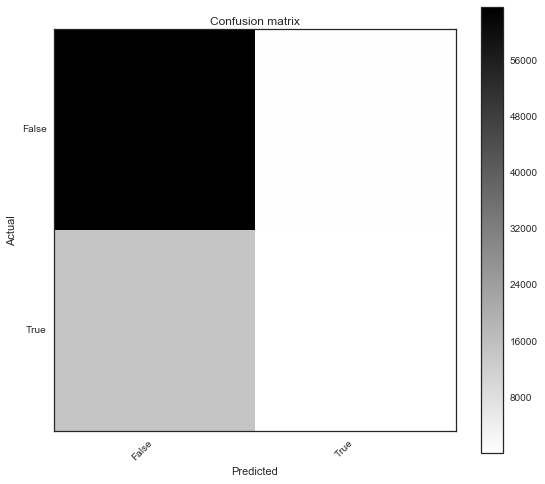

In [9]:
from sklearn.model_selection import cross_val_predict
from pandas_confusion import ConfusionMatrix

prediction = cross_val_predict(clf, X_train_scaled.loc[:,['grade']], y_train, cv=10)
confusion_matrix = ConfusionMatrix(y_train, prediction)
print(confusion_matrix)
confusion_matrix.plot()

0.506268826497


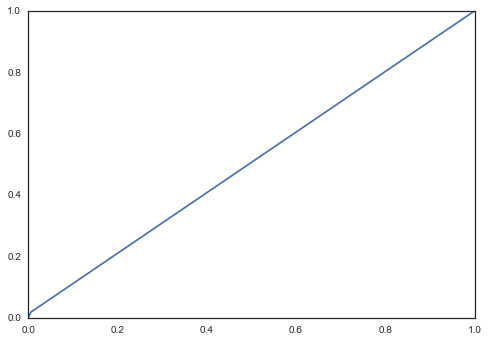

In [10]:
from sklearn.metrics import roc_curve, auc
fpr, tpr, thresholds = roc_curve(y_train, prediction, pos_label=True)
print(auc(fpr, tpr))  
plt.plot(fpr, tpr)

We can now include all the features we selected (24) and see if the prediction will be better. Because we use regularization, the effect of not useful features will be downgraded automatically. This leads to a slightly better F1-score of 0.751. Also the confusion matrix and the ROC-curve/AUC-score are a little better. Although still not great with an AUC score of 0.515. The top-5 features most used by the algorithm are: 'funded_amnt_inv', 'int_rate', 'sub_grade', 'funded_amnt' and 'annual_inc'. Not even grade itself.

In [11]:
clf = LogisticRegression(penalty='l1')
scores = cross_val_score(clf, X_train_scaled, y_train, cv=10, scoring='f1_weighted')
print(scores)  
print(np.mean(scores))

[ 0.75093668  0.75005361  0.75398879  0.752801    0.75166244  0.75361669
  0.75226473  0.7511663   0.75128231  0.75075621]
0.751852875899


Predicted  False  True  __all__
Actual                         
False      63354   861    64215
True       14603   224    14827
__all__    77957  1085    79042


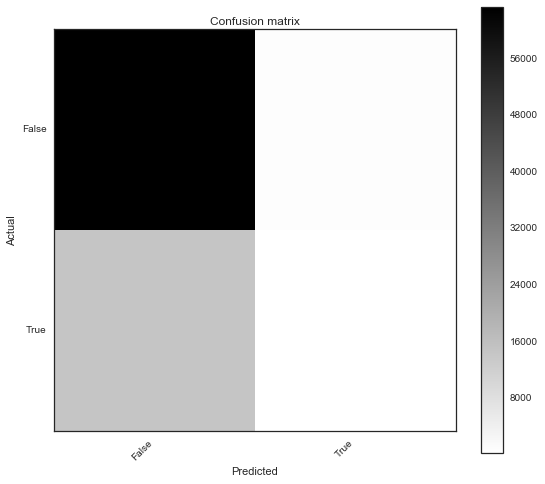

In [12]:
prediction = cross_val_predict(clf, X_train_scaled, y_train, cv=10)
confusion_matrix = ConfusionMatrix(y_train, prediction)
print(confusion_matrix)
confusion_matrix.plot()

0.515803090358


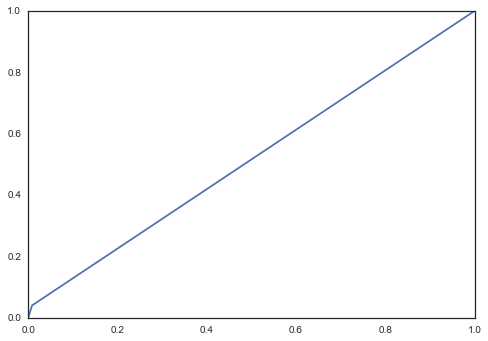

In [13]:
fpr, tpr, thresholds = roc_curve(y_train, prediction, pos_label=True)
print(auc(fpr, tpr))
plt.plot(fpr, tpr) 

In [14]:
clf = LogisticRegression(penalty='l1')
clf.fit(X_train_scaled, y_train)
coefs = clf.coef_

# find index of top 5 highest coefficients, aka most used features for prediction
positions = abs(coefs[0]).argsort()[-5:][::-1]
print(X_train_scaled.columns[positions])
print(coefs[0][positions])

Index(['funded_amnt_inv', 'int_rate', 'sub_grade', 'funded_amnt',
       'annual_inc'],
      dtype='object')
[-0.7416457   0.64371998 -0.39414366  0.37706219 -0.362611  ]


We can also pick only 5 features and see if this works better. But it works exactly the same as only grade. So SelectKBest does not work as well with 5 features as using all features.

In [15]:
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import mutual_info_classif
new_X = (SelectKBest(mutual_info_classif, k=5)
        .fit_transform(X_train_scaled, y_train))

In [16]:
print(new_X[0]) # term, int_rate, installement, grade, sub_grade
print(X_train_scaled.head())
new_X = pd.DataFrame(new_X, columns=['term', 'int_rate', 'installment', 'grade', 'sub_grade'])

[-0.53347328 -1.04927486 -1.44296973 -0.60375877 -0.7596471 ]
   funded_amnt_inv      term  int_rate  installment     grade  sub_grade  \
0        -1.396813 -0.533473 -1.049275    -1.442970 -0.603759  -0.759647   
1        -0.938935 -0.533473 -0.711339    -0.941786 -0.603759  -0.684304   
2        -1.150972 -0.533473  0.165467    -1.141149  0.141378   0.219819   
3        -0.877475 -0.533473 -0.633705    -0.871220 -0.603759  -0.608960   
4        -0.167610 -0.533473  1.078807     0.080347  0.886515   0.822568   

   emp_length  home_ownership  annual_inc   purpose    ...     inq_last_6mths  \
0   -0.158876        0.528548    0.721176  0.541018    ...           0.095378   
1   -0.158876       -1.054752   -0.771459  0.541018    ...           0.095378   
2   -0.158876        0.528548   -0.453877 -1.939754    ...           0.095378   
3   -0.964254       -1.054752   -0.148204  0.541018    ...          -0.763512   
4   -1.501173        2.111848   -0.199811  0.541018    ...           0.95426

In [17]:
clf = LogisticRegression(penalty='l1')
scores = cross_val_score(clf, new_X, y_train, cv=10, scoring='f1_weighted')
print(scores)  
print(np.mean(scores))

[ 0.74420676  0.74321254  0.74470698  0.74490208  0.74514106  0.74413862
  0.74437956  0.74366665  0.74445543  0.7433807 ]
0.744219037403


Predicted  False  True  __all__
Actual                         
False      63726   489    64215
True       14713   114    14827
__all__    78439   603    79042


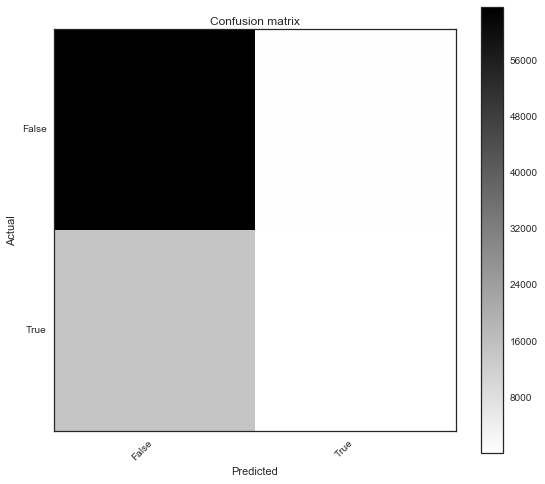

In [18]:
prediction = cross_val_predict(clf, new_X, y_train, cv=10)
confusion_matrix = ConfusionMatrix(y_train, prediction)
print(confusion_matrix)
confusion_matrix.plot()

0.506144944689


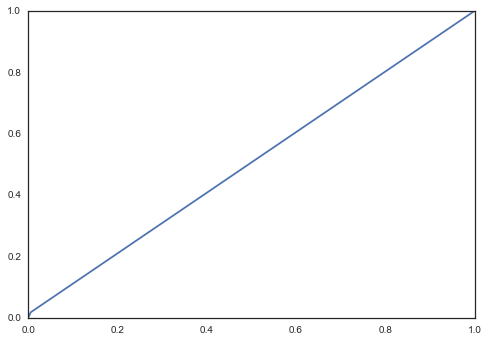

In [19]:
fpr, tpr, thresholds = roc_curve(y_train, prediction, pos_label=True)
print(auc(fpr, tpr))
plt.plot(fpr, tpr)

To see the statistical relevance of certain features, we can use the statsmodels package. We first use it with the 5 features selected by SelectKBest. We see there that only term, int_rate and installement are relevant. Confidence interval of all is small, but the coefficients of alle are also very close to 0, so do not seem to have a huge influence.

Subsequently we do the same for the 5 features with the highest coefficients in the regularized logistic regression that uses all features. Of these all features seem useful, except for 'sub_grade'. The coefficients are slightly higher and confidence intervals are small. Although the conclusions are contradictory. Funded_amnt and funded_amnt_inv have the highest coefficients. These two values should be roughly the same, but have a contradictory relation with the target value charged_off. This makes no sense and gives the idea that the algorithm is still pretty random.

In [20]:
import statsmodels.api as sm

print(new_X.columns)
logit = sm.Logit(y_train, np.array(new_X))
result = logit.fit()
print(result.summary())

Index(['term', 'int_rate', 'installment', 'grade', 'sub_grade'], dtype='object')
Optimization terminated successfully.
         Current function value: 0.675578
         Iterations 4
                           Logit Regression Results                           
Dep. Variable:                 Actual   No. Observations:               179003
Model:                          Logit   Df Residuals:                   178998
Method:                           MLE   Df Model:                            4
Date:                Wed, 18 Jan 2017   Pseudo R-squ.:                 -0.4335
Time:                        16:43:42   Log-Likelihood:            -1.2093e+05
converged:                       True   LL-Null:                       -84359.
                                        LLR p-value:                     1.000
                 coef    std err          z      P>|z|      [95.0% Conf. Int.]
------------------------------------------------------------------------------
x1             0.0912      

In [21]:
logit = sm.Logit(y_train, np.array(
        X_train_scaled.loc[:,['funded_amnt_inv', 'int_rate', 'sub_grade', 'funded_amnt', 'annual_inc']]))
result = logit.fit()
print(result.summary())

Optimization terminated successfully.
         Current function value: 0.674582
         Iterations 5
                           Logit Regression Results                           
Dep. Variable:                 Actual   No. Observations:               179003
Model:                          Logit   Df Residuals:                   178998
Method:                           MLE   Df Model:                            4
Date:                Wed, 18 Jan 2017   Pseudo R-squ.:                 -0.4314
Time:                        16:43:42   Log-Likelihood:            -1.2075e+05
converged:                       True   LL-Null:                       -84359.
                                        LLR p-value:                     1.000
                 coef    std err          z      P>|z|      [95.0% Conf. Int.]
------------------------------------------------------------------------------
x1            -0.4328      0.044     -9.879      0.000        -0.519    -0.347
x2             0.3384      0.

Another way to possibly increase performance is to tune the C (penalization) parameter. We will do this with the GridSearchCV function of sklearn. The best performing C parameter, although really close with the default, is C=1. Giving an accuracy of 0.752. (code is quoted out because it takes a long time to run)

In [22]:
from sklearn.model_selection import GridSearchCV
dict_Cs = {'C': [0.001, 0.1, 1, 10, 100]}
clf = GridSearchCV(LogisticRegression(penalty='l1'), dict_Cs, 'f1_weighted', cv=10)

clf.fit(X_train_scaled, y_train)
print(clf.best_params_)
print(clf.best_score_)

{'C': 1}
0.751877292767


### Random Forest

To improve accuracy levels we could use a more complicated algorithm that scores well in a lot of cases, namely random forest. This algorithm makes various decision trees from subsets of the samples and uses at each split only a fraction of the features to prevent overfitting. The random forest algorithm is known to be not very sensitive to the values of its parameters: the number of features used at each split and the number of trees in the forest. Nevertheless, the default of sklearn is so low that we will raise the number of trees to 100. The algorithm has feature selection already builtin (at each split) and scaling/normalization is also not necessary. 

We will first run the algorithm with only grade. This makes not that much sense for Random Forest, since it builds trees. And you cannot build a tree from only one feature. Nevertheless, this will be our starting point. The F1 score is 0.739 hence slightly lower than logistic regression. As expected is the confusion matrix dramatic, namely the algorithm turns out to just predict everything as fully paid. And that's why the AUC-score is exactly random. 

In [23]:
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import RandomForestClassifier
clf = RandomForestClassifier(n_estimators=100)
scores = cross_val_score(clf, X_train.loc[:,['grade']], y_train, cv=10, scoring='f1_weighted')
print(scores)
print(np.mean(scores))

/Users/ro.d.bruijn/anaconda/lib/python3.5/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/ro.d.bruijn/anaconda/lib/python3.5/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/ro.d.bruijn/anaconda/lib/python3.5/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/ro.d.bruijn/anaconda/lib/python3.5/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/r

[ 0.73899314  0.73899314  0.73899314  0.73899314  0.73899314  0.73899314
  0.7390571   0.73904307  0.73904307  0.73904307]
0.739014513169


Predicted  False  True  __all__
Actual                         
False      64215     0    64215
True       14827     0    14827
__all__    79042     0    79042


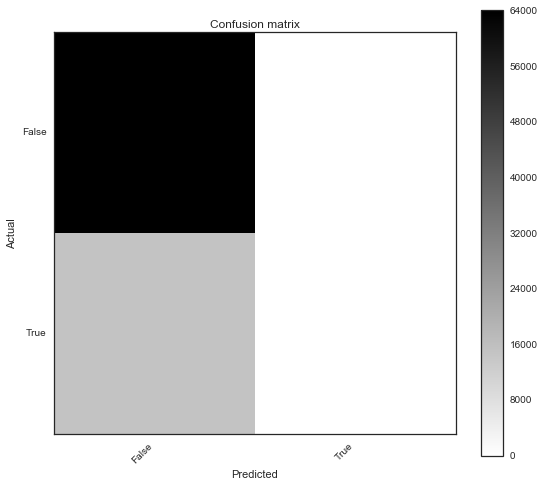

In [24]:
prediction = cross_val_predict(clf, X_train.loc[:,['grade']], y_train, cv=10)
confusion_matrix = ConfusionMatrix(y_train, prediction)
print(confusion_matrix)
confusion_matrix.plot()

0.5


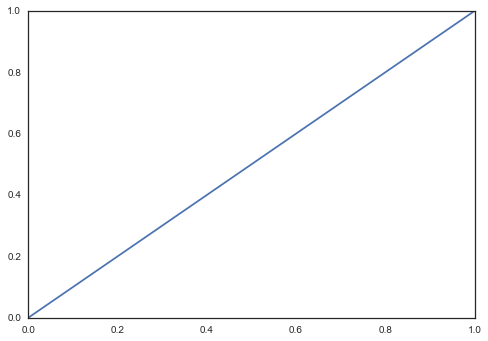

In [25]:
fpr, tpr, thresholds = roc_curve(y_train, prediction, pos_label=True)
print(auc(fpr, tpr))
plt.plot(fpr, tpr)

Trying the algorithm with all the features (24) leads to a slightly higher F1-score of 0.750. But logistic regression with all features was a fraction better than that. Also the confusion matrix and AUC is comparable but slightly worse than the logistic regression algorithm with all features. The random forest classifier does select a different top-5 features, namely 'dti', 'revol_bal', 'revol_util', 'annual_inc' and 'int_rate'. 

In [26]:
clf = RandomForestClassifier(n_estimators=100)
scores = cross_val_score(clf, X_train, y_train, cv=10, scoring='f1_weighted')
print(scores)
print(np.mean(scores))

[ 0.74879267  0.7502452   0.75261391  0.74963585  0.75112529  0.75025658
  0.75013348  0.74812531  0.7499637   0.75043025]
0.750132225296


Predicted  False  True  __all__
Actual                         
False      63456   759    64215
True       14625   202    14827
__all__    78081   961    79042


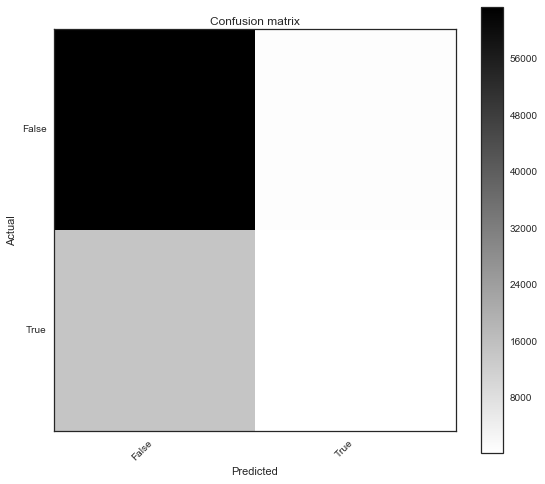

In [27]:
prediction = cross_val_predict(clf, X_train, y_train, cv=10)
confusion_matrix = ConfusionMatrix(y_train, prediction)
print(confusion_matrix)
confusion_matrix.plot()

0.513419131632


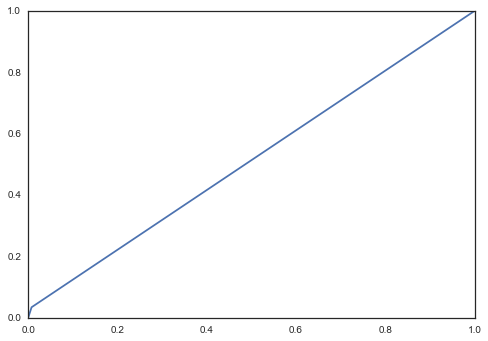

In [28]:
fpr, tpr, thresholds = roc_curve(y_train, prediction, pos_label=True)
print(auc(fpr, tpr))
plt.plot(fpr, tpr)

In [29]:
clf = RandomForestClassifier(n_estimators=100)
clf.fit(X_train, y_train)
feat_imp = clf.feature_importances_

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19, 20, 21, 22, 23]), <a list of 24 Text xticklabel objects>)

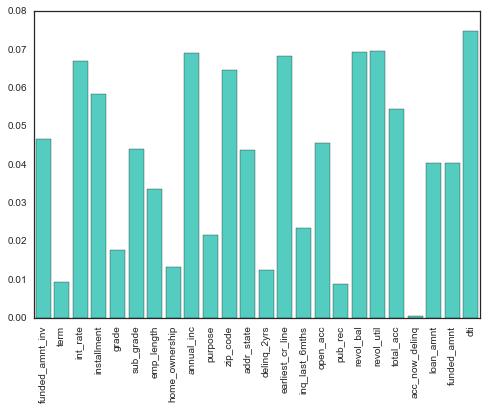

In [30]:
sns.barplot(x=X_train.columns, y=feat_imp, color='turquoise')
plt.xticks(rotation=90)

In [31]:
positions = abs(feat_imp).argsort()[-5:][::-1]
print(X_train.columns[positions])
print(feat_imp[positions])

Index(['dti', 'revol_util', 'revol_bal', 'annual_inc', 'earliest_cr_line'], dtype='object')
[ 0.07490979  0.06955051  0.06947281  0.06912128  0.06833512]


### Test set
To test the accuracies of our algorithms we first have to do the same transformations on the test set as we did on the training set. So we will transform the categorical features to numerical and replace nan/inf/-inf with 0. Also for the logistic regression algorithm we normalized and scaled the training set and we saved these transformations, so we can do the exact same tranformation on the test set.

In [32]:
# date
X_test['earliest_cr_line'] = pd.to_datetime(X_test['earliest_cr_line']).dt.strftime("%s")
X_test['earliest_cr_line'] = [0 if date=='NaT' else int(date) for date in X_test['earliest_cr_line']]

# term
X_test['term'] = X_test['term'].apply(lambda x: int(x.split(' ')[1]))

# grade
X_test['grade'] = X_test['grade'].apply(lambda x: grade_dict[x])

# emp_length
X_test['emp_length'] = X_test['emp_length'].apply(lambda x: emp_length_dict[x])

# zipcode
X_test['zip_code'] = X_test['zip_code'].apply(lambda x: int(x[0:3]))

# subgrade
X_test['sub_grade'] = X_test['grade'] + X_test['sub_grade'].apply(lambda x: float(list(x)[1])/10)

# house
X_test['home_ownership'] = X_test['home_ownership'].apply(lambda x: house_dict[x])

# purpose
X_test['purpose'] = X_test['purpose'].apply(lambda x: purpose_dict[x])

# states
X_test['addr_state'] = X_test['addr_state'].apply(lambda x: state_dict[x])

# make NA's, inf and -inf 0
X_test = X_test.fillna(0)
X_test = X_test.replace([np.inf, -np.inf], 0)

In [33]:
X_test_scaled = scaler.transform(X_test)
X_test_scaled = pd.DataFrame(X_test_scaled, columns=X_test.columns)

#### logistic regression

For logistic regression we will test both the 'only grade' algorithm (baseline) and the best performing algorithm (C=1, all features with regularization). We find practically the same F-scores/confusion matrices/ROC-curves/AUC-scores as for the training set. Therefore the crossvalidation scheme used on the training set gives reliable accuracy measurements. But it's clear that the predictive value of the algorithm increases slightly with more features, but it's basically predicting that all loans get fully paid and therefore the accuracy scores are practically random. 

0.744556170299
Predicted  False  True  __all__
Actual                         
False      13926   115    14041
True        2828    17     2845
__all__    16754   132    16886


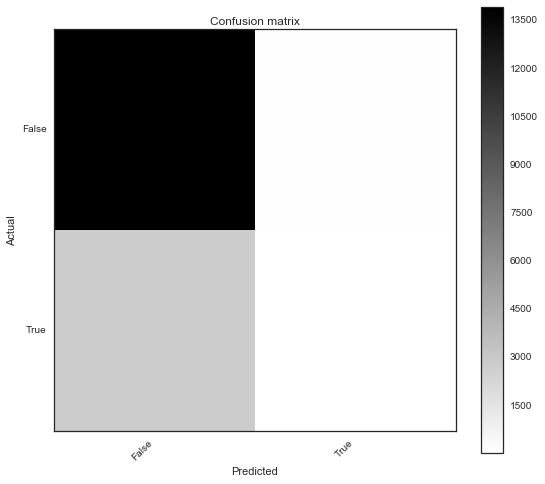

In [34]:
from sklearn.metrics import f1_score

clf = LogisticRegression(penalty='l1', C=1)
clf.fit(X_train_scaled.loc[:,['grade']], y_train)
prediction = clf.predict(X_test_scaled.loc[:,['grade']])
print(f1_score(y_test, prediction, average='weighted'))
confusion_matrix = ConfusionMatrix(y_test, prediction)
print(confusion_matrix)
confusion_matrix.plot()

0.506593541808


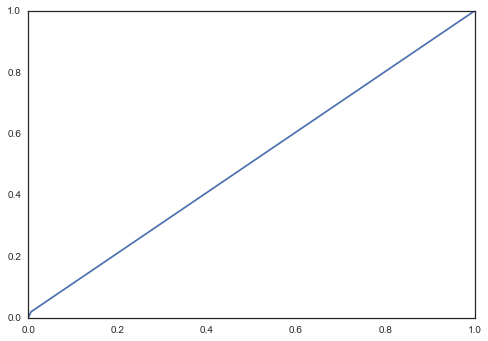

In [35]:
fpr, tpr, thresholds = roc_curve(y_test, prediction, pos_label=True)
print(auc(fpr, tpr))
plt.plot(fpr, tpr)

0.75193320632
Predicted  False  True  __all__
Actual                         
False      13817   224    14041
True        2802    43     2845
__all__    16619   267    16886


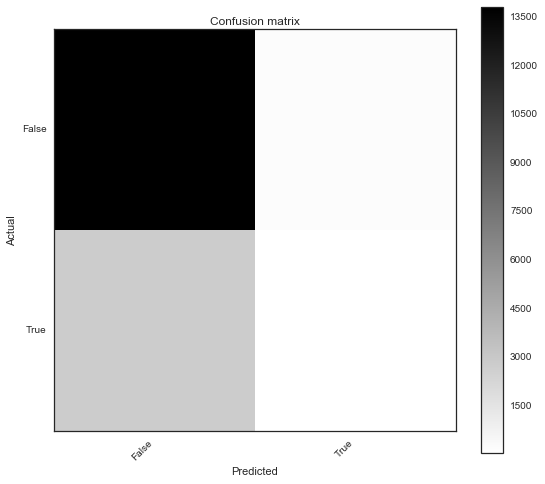

In [36]:
clf = LogisticRegression(penalty='l1', C=1)
clf.fit(X_train_scaled, y_train)
prediction = clf.predict(X_test_scaled)
print(f1_score(y_test, prediction, average='weighted'))
confusion_matrix = ConfusionMatrix(y_test, prediction)
print(confusion_matrix)
confusion_matrix.plot()

0.515940013317


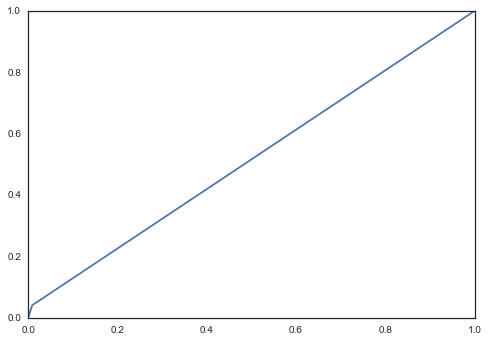

In [37]:
fpr, tpr, thresholds = roc_curve(y_test, prediction, pos_label=True)
print(auc(fpr, tpr))
plt.plot(fpr, tpr)

#### Random Forest

Also with the random forest algorithm for both only grade and all features we find the same accuracy measurements as measured with cross-validation on the training set. Therefore the logistic regression algorithm with all features still performance the best, although it performs not very well. 

0.739008115086
Predicted  False  True  __all__
Actual                         
False      14041     0    14041
True        2845     0     2845
__all__    16886     0    16886


/Users/ro.d.bruijn/anaconda/lib/python3.5/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


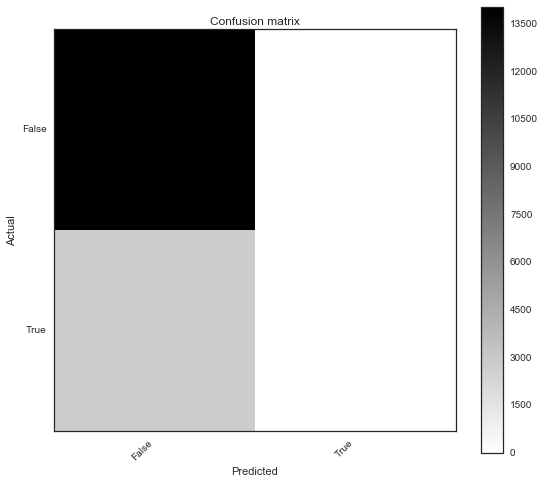

In [38]:
clf = RandomForestClassifier(n_estimators=100)
clf.fit(X_train.loc[:,['grade']], y_train)
prediction = clf.predict(X_test.loc[:,['grade']])
print(f1_score(y_test, prediction, average='weighted'))
confusion_matrix = ConfusionMatrix(y_test, prediction)
print(confusion_matrix)
confusion_matrix.plot()

0.5


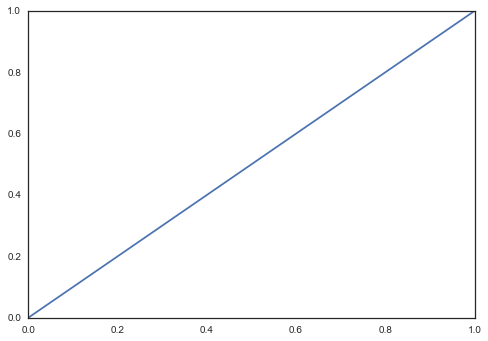

In [39]:
fpr, tpr, thresholds = roc_curve(y_test, prediction, pos_label=True)
print(auc(fpr, tpr))
plt.plot(fpr, tpr)

0.749546167697
Predicted  False  True  __all__
Actual                         
False      13872   169    14041
True        2802    43     2845
__all__    16674   212    16886


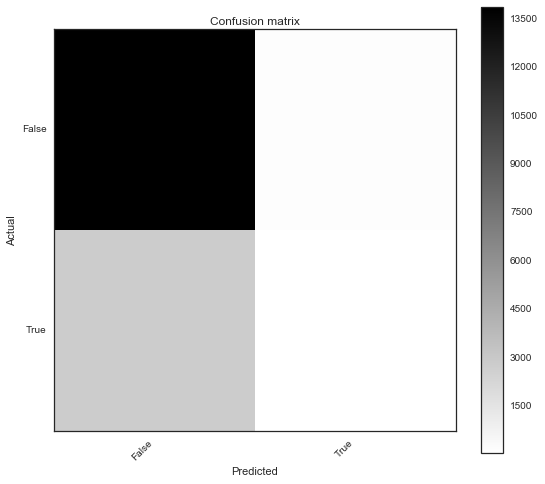

In [40]:
clf = RandomForestClassifier(n_estimators=100)
clf.fit(X_train, y_train)
prediction = clf.predict(X_test)
print(f1_score(y_test, prediction, average='weighted'))
confusion_matrix = ConfusionMatrix(y_test, prediction)
print(confusion_matrix)
confusion_matrix.plot()

0.512828844038


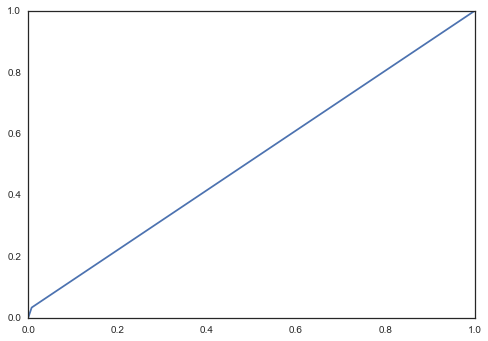

In [41]:
fpr, tpr, thresholds = roc_curve(y_test, prediction, pos_label=True)
print(auc(fpr, tpr))
plt.plot(fpr, tpr)